In [9]:
import numpy as np
import matplotlib.pyplot as plt
def remove_i(x, i):
    """Drops the ith element of an array."""
    shape = (x.shape[0]-1,) + x.shape[1:]
    y = np.empty(shape, dtype=float)
    y[:i] = x[:i]
    y[i:] = x[i+1:]
    return y

def a(i, x, G, m):
    """The acelleration of the ith mass."""
    x_i = x[i]
    x_j = remove_i(x, i)
    m_j = remove_i(m, i)
    diff = x_j - x_i
    mag3 = np.sum(diff**2, axis=1)**1.5
    result = G * np.sum(diff * (m_j / mag3)[:,np.newaxis], axis=0)
    return result

In [10]:
from threading import Thread

class Worker(Thread):
    """Computes x, v, and a of the ith body."""
    def __init__(self, *args, **kwargs):
        super(Worker, self).__init__(*args, **kwargs)
        self.inputs = []
        self.results = []
        self.running = True
        self.daemon = True
        self.start()
        
    def run(self):
        while self.running:
            if len(self.inputs) == 0:
                continue
            i, x0, v0, G, m, dt = self.inputs[0]
            a_i0 = a(i, x0, G, m)
            v_i1 = a_i0 * dt + v0[i]
            x_i1 = a_i0 * dt**2 + v0[i] * dt + x0[i]
            result = (i, x_i1, v_i1)
            self.results.append(result)
            del self.inputs[0]
            
class Pool(object):
    """A collection of P worker threads that disrtibutes tasks 
    evenly across them.
    """
    def __init__(self, size):
        self.size = size
        self.workers = [Worker() for p in range(size)]
        
    def do(self, tasks):
        for p in range(self.size):
            self.workers[p].inputs += tasks[p::self.size]
        while any([len(worker.inputs) != 0 for worker in self.workers]):
            pass
        results = []
        for worker in self.workers:
            results += worker.results
            worker.results.clear()
        return results
    
    def __del__(self):
        for worker in self.workers:
            worker.running = False

In [11]:
def timestep(x0, v0, G, m, dt, pool):
    """Computes the next position and velocity for all masses given 
    a initial conditions and a time step size.
    """
    N = len(x0)
    tasks = [(i, x0, v0, G, m, dt) for i in range(N)]
    results = pool.do(tasks)
    x1 = np.empty(x0.shape, dtype=float)
    v1 = np.empty(v0.shape, dtype=float)
    for i, x_i1, v_i1 in results:
        x1[i] = x_i1
        v1[i] = v_i1
    return x1, v1

def initial_cond(N, D):
    """Generates initial conditions for N unity masses at rest 
    starting at random positions in D-dimensional space.
    """
    x0 = np.random.rand(N, D)
    v0 = np.zeros((N, D), dtype=float)
    m = np.ones(N, dtype=float)
    return x0, v0, m    

In [12]:
def makefig(x, v, t):
    plt.plot(x[:,0], x[:,1], 'ro')
    if not np.all(v == 0.0):
        plt.quiver(x[:,0], x[:,1], v[:,0], v[:,1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Time t = {0}'.format(t))
    plt.savefig('n-body-t{0}.svg'.format(t))

In [13]:
%%time
x0, v0, m = initial_cond(10, 2)
pool = Pool(4)
x1, v1 = timestep(x0, v0, 1.0, m, 1.0e-3, pool)
del pool

Wall time: 1.2 s


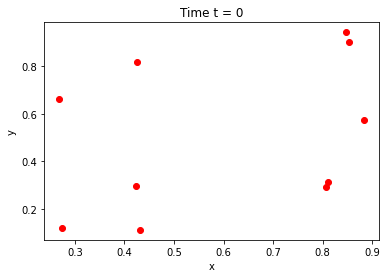

In [14]:
makefig(x0, v0, 0)

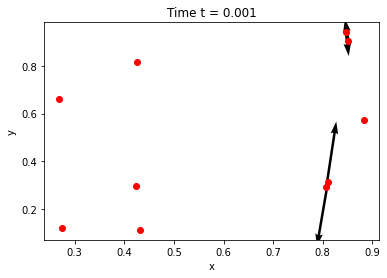

In [15]:
makefig(x1, v1, 1e-3)

In [16]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 1.0), ylim=(0, 1.0))
viewport = [0.0, 1.0, 0.0, 1.0]

N = 10
x0, v0, m = initial_cond(N, 2)
pool = Pool(4)

def init():
    ax.clear()
    ax.plot(x0[:,0], x0[:,1], 'ro')
    ax.quiver(x0[:,0], x0[:,1], v0[:,0], v0[:,1])
    ax.axis(viewport)
    return ax

def animate(i):
    global x0, v0, pool
    x, v = timestep(x0, v0, 1.0, m, 1.0e-3, pool)
    ax.clear()
    ax.plot(x[:,0], x[:,1], 'ro')
    ax.quiver(x[:,0], x[:,1], v[:,0], v[:,1])
    ax.axis(viewport)
    x0, v0 = x, v
    return ax

animation.FuncAnimation(fig, animate, frames=3, init_func=init, interval=100)

TypeError: setup() got an unexpected keyword argument 'clear_temp'

In [17]:
del pool

In [18]:
def simulate(P, N, D, S, G, dt):
    x0, v0, m = initial_cond(N, D)
    pool = Pool(P)
    for s in range(S):
        x1, v1 = timestep(x0, v0, G, m, dt, pool)
        x0, v0 = x1, v1

In [19]:
%%time
import time
Ps = [1, 2, 4, 8]
runtimes = []
for P in Ps:
    print("running", P)
    start = time.time()
    simulate(P, 64, 3, 300, 1.0, 1e-3)
    stop = time.time()
    runtimes.append(stop - start)
print(runtimes)

running 1


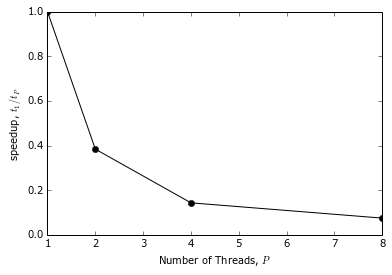

In [ ]:
rts = runtimes[0] / np.array(runtimes) 
plt.plot(Ps, rts, 'ko-')
plt.xlabel('Number of Threads, $P$')
plt.ylabel('speedup, $t_1/t_P$')
plt.savefig('n-body-thread-speedup.svg')

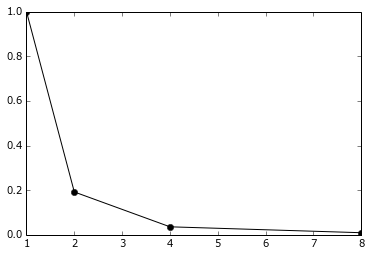

In [ ]:
plt.plot(Ps, rts / Ps, 'ko-')

In [ ]:
rts

array([ 1.        ,  0.3839154 ,  0.14316012,  0.07480475])

In [ ]:
rts[1:] / rts[:-1]

array([ 0.3839154 ,  0.37289495,  0.52252506])

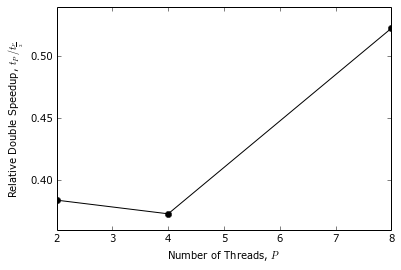

In [ ]:
plt.plot(Ps[1:], rts[1:] / rts[:-1], 'ko-')
plt.xlabel('Number of Threads, $P$')
plt.ylabel('Relative Double Speedup, $t_P/t_{\\frac{P}{2}}$')
plt.savefig('n-body-thread-double-speedup.svg')

In [ ]:
runtimes[0]/1.9455578327178955

28.79767767231955